# Tutorial: Reinforcement learning through Self-play for Super-Tic-Tac-Toe

This notebook aims to give a simple tutorial of the running logic of this project. Here is the outline:
   1. Super-Tic-Tac-Toe environment
   2. Double DQN agent
   3. Replay buffer
   4. Training/Evaluation

## 1. Super-Tic-Tac-Toe environment

The environment [Super-Tic-Tac-Toe](envs/super_tic_tac_toe.py) extends the original Tic-Tac-Toe environment by introducing two features to increase the difficulty: larger board (6x6) and stochastic transitions. 

Mimicking how human visually read a board state, I represent the board state as a 6x6x2 0-1 tensor with 1 indicating occupied positions and 0 empty cells, respectively. Here are two channels for each cell with each corresponding to one specific player. Here is how to initialize an environment:


In [1]:
import random
import numpy as np
from envs import SuperTicTacToeEnv

random.seed(0)
np.random.seed(0)


env = SuperTicTacToeEnv(random_place_prob=0.5)  # set random_place_prob=0.5 to be the same as the project requirement

board, la_mask, player_id, done = env.reset()
        
print('board shape =', board.shape)
print('legal_actions mask shape =', la_mask)  # 1 indicates available actions, explained later
print('current player_id =', player_id)

print('The initial board:')
env.render()

board shape = (6, 6, 2)
legal_actions mask shape = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
current player_id = 1
The initial board:
| _  _  _  _  _  _ |
| _  _  _  _  _  _ |
| _  _  _  _  _  _ |
| _  _  _  _  _  _ |
| _  _  _  _  _  _ |
| _  _  _  _  _  _ |


Each environment step receives an action and returns several useful information: `board state`, `legal action mask`, `current player id`, `done signal` and the `rewards`. The accepted action is one of the 36 integers ranging from 0 to 35, indicating the position index.

The default setting for reward value is: +1 for winning, -1 for losing, 0 for tie or continuing.

The initial player is randomly chosen for fairness. Here I finish the game with randomly chosen actions. You can visually check the board using `env.render()` method.

In [2]:
# finish the game with random actions
while not done:
    a = np.random.choice(env.get_legal_actions())
    (board, la_mask, player_id, done), rewards = env.step(a)

print('winner =', env.winner)
print('rewards =', rewards)
print('Visualizing the env:')
env.render()

winner = 1
rewards = [-1, 1]
Visualizing the env:
| X  O  _  _  O  _ |
| O  X  X  X  X  X |
| X  _  _  O  O  _ |
| _  X  _  X  O  X |
| O  X  O  _  _  _ |
| _  _  O  _  _  O |


There are **54** winner patterns. Here I list 3 examples:

In [3]:
winner_patterns = env.get_winner_pattern()

print('# of winner patterns =', len(winner_patterns))
env.render(winner_patterns[0])  # row example
env.render(winner_patterns[21])  # column example
env.render(winner_patterns[50])  # diagonal example

# of winner patterns = 54
| O  O  O  O  _  _ |
| _  _  _  _  _  _ |
| _  _  _  _  _  _ |
| _  _  _  _  _  _ |
| _  _  _  _  _  _ |
| _  _  _  _  _  _ |

| _  _  _  _  _  _ |
| _  _  _  O  _  _ |
| _  _  _  O  _  _ |
| _  _  _  O  _  _ |
| _  _  _  O  _  _ |
| _  _  _  _  _  _ |

| _  _  _  _  _  _ |
| _  _  _  _  _  _ |
| _  O  _  _  _  _ |
| _  _  O  _  _  _ |
| _  _  _  O  _  _ |
| _  _  _  _  O  _ |


### Observations (reinforcement learning states)

The Super-Tic-Tac-Toe is a perfect information game, where the board state is fully observable for both players, i.e., the *observations* are the same as the environment *states*. However, the `env.board` is not the observation used by the agent, as the agent should also know its player_id as well.
 
To simply the representation of the observations for the neural network agent to learn, I define the observations as **6x6x2** images with a little re-arrangement of the `env.board`: with the first channel **always** representing 'my positions' and the second channel **always** encoding the 'opponent positions'. That is I need to fetch the board state using the player_id:
 
`observation = board[:, :, [player_id, 1-player_id]]`.

In [4]:
my_obs = board[:, :, [player_id, 1-player_id]]

print('my player_id = ', player_id)
print("my observations ('O' for myself and 'X' for the opponent):")
env.render(my_obs)

print('my positions:')
env.render(my_obs[:, :, 0], mark=player_id)

print('opponent positions:')
env.render(my_obs[:, :, 1], mark=1 - player_id)



my player_id =  0
my observations ('O' for myself and 'X' for the opponent):
| X  O  _  _  O  _ |
| O  X  X  X  X  X |
| X  _  _  O  O  _ |
| _  X  _  X  O  X |
| O  X  O  _  _  _ |
| _  _  O  _  _  O |

my positions:
| _  O  _  _  O  _ |
| O  _  _  _  _  _ |
| _  _  _  O  O  _ |
| _  _  _  _  O  _ |
| O  _  O  _  _  _ |
| _  _  O  _  _  O |

opponent positions:
| X  _  _  _  _  _ |
| _  X  X  X  X  X |
| X  _  _  _  _  _ |
| _  X  _  X  _  X |
| _  X  _  _  _  _ |
| _  _  _  _  _  _ |


### Actions

Each action is an integer ranging from 0 to 35, indicating the index of the 6x6 board cells. The action should be chosen from the legal action sets (empty positions). The environment provides 2 ways for choosing legal action: masks and sets. 

* The `legal action masks` *m* are convenient for downstream probabilistic polices. For example, if the predicted policy distribution is *p* (36-dim vector), then the action can be sampled from *p Hadamard_product m*, where the occupied positions always have zero sampling probability.

* The `legal action set` is convenient for some other methods, such as Monte-Carlo Tree Search.

You can choose your own preferences for legal action representations.

In [5]:
# 1. legal action masks: 1 for available positions; 0 for occupied positions
print('legal action masks from env.step:', la_mask)

# 2. index set of legal actions
print('legal action set:', env.get_legal_actions())

legal action masks from env.step: [0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0.]
legal action set: [2, 3, 5, 13, 14, 17, 18, 20, 27, 28, 29, 30, 31, 33, 34]


## 2. Double DQN agent

For simplicity, I define the [base agent framework](agents/agent.py) in my code. Each agent should define its own `update(self, batch: Batch)` method for how to train from a data batch and the `sample_actions(self, *args, **kwargs)` method for how to sample actions. 

The Double DQN agent requires two Q-networks: a policy Q-network and a target Q-network. The policy Q-network is trained directly through the gradient descent. The target Q-network is the exponential moving average of learned policy Q-network.

As the board observations is much like images with 2 channels, I define the Q-network as a 2D convolutional neural network for the game:

* Layers: 3 hidden layers with each of the dimensions equaling 64, the final activation of CNN layers squeezes the dimension to 1.
* Activation: [mish](https://arxiv.org/abs/1908.08681).
* Final activation layer: a MLP layer to project the activation of the CNN to the action dimension by `nn.Dense(out_dim)(x.reshape(x.shape[0], -1))`.

Here is a summary of the Q-network module represented as a table:

In [6]:
import jax
from flax import linen as nn
from networks.mlp import CNN, mish

critic_def = CNN(hidden_dims=(64, 64, 64, 1),
                 out_dim=36,  # number of action dimensions = 36
                 activations=mish,  # A Self Regularized Non-Monotonic Activation Function
                 dropout_rate=0.,
                 layer_norm=False)

print(nn.tabulate(critic_def, jax.random.key(0), compute_flops=True, compute_vjp_flops=True)(jax.numpy.zeros((1,6,6,2))))


                                  CNN Summary                                   
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs     ┃ outputs   ┃ flops   ┃ vjp_flops ┃ params     ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━┩
│         │ CNN    │ float32[1… │ float32[… │ 4364395 │ 13128384  │            │
├─────────┼────────┼────────────┼───────────┼─────────┼───────────┼────────────┤
│ Conv_0  │ Conv   │ float32[1… │ float32[… │ 67840   │ 202368    │ bias:      │
│         │        │            │           │         │           │ float32[6… │
│         │        │            │           │         │           │ kernel:    │
│         │        │            │           │         │           │ float32[3… │
│         │        │            │           │         │           │            │
│         │        │            │           │         │           │ 1,216 (4.9 │
│         │        │       

The packaged Double DQN agent is given in the [dqn.py](agents/dqn.py) script. In my tutorial, I follow some conventional settings to create the agent:

* Discount rate: 0.99
* Epsilon greedy: starting from 1 and linearly decay to 0.01
* Gradient descent: [Adam](https://arxiv.org/abs/1412.6980) with cosine decay learning rate, starting from 0.0003
* Updating target Q-network: exponential moving average with learning rate 0.005

Here is an example of defining the agent: `max_steps` defines the total number of gradient steps. It may take a much larger value (> 10 million) to converge!


In [7]:
from agents import DQNLearner

max_steps = 10000
agent = DQNLearner(seed=0,
                   hidden_dims=(64, 64, 64, 1),
                   obs_shape=(6, 6, 2),
                   act_dim=36,
                   lr_decay_steps=max_steps,
                   greedy_max=1,
                   greedy_min=0.01,
                   greedy_decay_steps=50,
                   ema_tau=0.005)

In the training process of Double DQN, the Bellman target is computed requiring both the policy Q-network and the target Q-network. The policy Q-network gives the greedy actions while the target Q-network evaluate the greedy actions to alleviate the overestimation. See the [paper](https://arxiv.org/abs/1509.06461v3) or my [codes](agents/dqn.py) for the details of the implementation of Double DQN

## 3. Replay buffer

The replay buffer stores the transitions for the Q-learning. Each transition contains a tuple: 

``
(observation, action, reward, next_observation, mask).
``

The `mask = 1 - done` is for computing the Bellman target `target_q = reward + discount * masks * next_q`. 

In this game, the board has rotation symmetries: a board rotated by `n*90` degrees actually gives the same observation. To increase the sampling efficiency, we can expand the transition data by rotating the board observation by `n*90 (n=1, 2, 3)` degrees and store them into the buffer as well. 

In fact, the reflection (transpose) transformation also gives the same observations. Furthermore, each transformation with the minimal rotation granularity = 90-degree inside the orthogonal group O(6) also gives the same observations. For simplicity, here I only consider the rotations. You can try other symmetry transforms as you like.

Here are examples of rotations:

In [8]:
print('my observations:')
env.render(my_obs)
print('rotated 90 degrees:')
env.render(np.rot90(my_obs))
print('rotated 180 degrees:')
env.render(np.rot90(np.rot90(my_obs)))
print('rotated 270 degrees:')
env.render(np.rot90(np.rot90(np.rot90(my_obs))))

my observations:
| X  O  _  _  O  _ |
| O  X  X  X  X  X |
| X  _  _  O  O  _ |
| _  X  _  X  O  X |
| O  X  O  _  _  _ |
| _  _  O  _  _  O |

rotated 90 degrees:
| _  X  _  X  _  O |
| O  X  O  O  _  _ |
| _  X  O  X  _  _ |
| _  X  _  _  O  O |
| O  X  _  X  X  _ |
| X  O  X  _  O  _ |

rotated 180 degrees:
| O  _  _  O  _  _ |
| _  _  _  O  X  O |
| X  O  X  _  X  _ |
| _  O  O  _  _  X |
| X  X  X  X  X  O |
| _  O  _  _  O  X |

rotated 270 degrees:
| _  O  _  X  O  X |
| _  X  X  _  X  O |
| O  O  _  _  X  _ |
| _  _  X  O  X  _ |
| _  _  O  O  X  O |
| O  _  X  _  X  _ |


The corresponding actions should also be carefully transferred to match the rotated broads. The transformation is given as the following:

``
row, col = action // 6, action % 6
``
``
rotated_action = 6 * (5 - col) + row
``

Here is an example of action rotation:

In [9]:
action = 16  # just an example

# rotate 90 degrees
row, col = action // 6, action % 6
rotated_action = 6 * (5 - col) + row

# visualization
action_board = np.zeros((6, 6, 2))
action_board[:, :, 0].reshape(-1)[action] = 1
action_board[:, :, 1].reshape(-1)[rotated_action] = 1
print("Action (marked as 'O') is rotated 90 degrees to a new position (marked as 'X'): ")
env.render(action_board)



Action (marked as 'O') is rotated 90 degrees to a new position (marked as 'X'): 
| _  _  _  _  _  _ |
| _  _  X  _  _  _ |
| _  _  _  _  O  _ |
| _  _  _  _  _  _ |
| _  _  _  _  _  _ |
| _  _  _  _  _  _ |


Then, it is ready to define a replay buffer with capacity=1000000 with rotation expansions:

In [10]:
from datasets.replay_buffer import ReplayBuffer

replay_buffer = ReplayBuffer(obs_shape=(6, 6, 2),
                             capacity=1000000,
                             rotation_expand_k=3)  # rotated at most 3x90 degrees

## 4. Training/Evaluation

Up to now, we are prepared with the environment to interact with, the agent ready to learn and the replay buffer to store the online transition data. It is time to define the training and the evaluation process. In this tutorial, I use the random agent as the evaluation opponents. It can be replaced by any pre-trained stronger agents.

Let's re-define the environment, the agents and the replay buffer here for completeness:

In [11]:
# some additional imports
from matplotlib import pyplot as plt
from envs.super_tic_tac_toe import evaluate_tic_tac_toe
from tqdm import tqdm
from agents import RandomAgent

"""
In my main.py script, I use the tensorboard for statistics tracking. 
Here I just plot the curves for the tutorial purpose
"""


# Hyperparameters
max_steps = 100000  # the max number of gradient steps
update_interval = 100  # the frequency for gradient descent
eval_interval = 1000  # the frequency for evaluation
num_eval = 100  # the number of evaluation repetition
log_interval = 500  # the frequency for logging training information
buffer_size = 1000000
batch_size = 256


# Environments
env = SuperTicTacToeEnv(random_place_prob=0.5)  # the main environment to interaction with
eval_env = SuperTicTacToeEnv(random_place_prob=0.5)  # for evaluation only

# Agents
agent = DQNLearner(seed=0,
                   hidden_dims=(64, 64, 64, 1),
                   obs_shape=(6, 6, 2),
                   act_dim=36,
                   lr_decay_steps=max_steps,
                   greedy_max=1,
                   greedy_min=0.01,
                   greedy_decay_steps=max_steps // update_interval // 2)
ts_agent = RandomAgent()  # for evaluation only, as the opponent agent

# replay buffer
replay_buffer = ReplayBuffer(obs_shape=(6, 6, 2),
                             capacity=buffer_size,
                             rotation_expand_k=3) 



### Here is the main training/evaluation process:

In [12]:

avg_winning_rate, eval_t = [], []
training_stat, training_t = {}, []

# process bar
num_steps = 0
bar = tqdm(total=max_steps,
           desc=f'Train Agent={agent.name}',
           smoothing=0.01,
           colour='GREEN')

 # main train/test process
while num_steps < max_steps:
    board, la, player_id, done = env.reset()

    # record transitions for saving to the replay buffer
    obs = [None, None]
    actions = [None, None]
    next_obs = [None, None]
    obs[player_id] = board[:, :, [player_id, 1 - player_id]]

    # each game process
    while not done:
        action = ts_agent.sample_actions(observations=board[:, :, [player_id, 1 - player_id]][np.newaxis, :],
                                         legal_actions=la[np.newaxis, :])

        actions[player_id] = action

        # in super-TTT game: rewards = +1 for winner, -1 for loser, 0 for tie or continuing
        (board, la, player_id, done), rewards = env.step(action)
        next_obs[player_id] = board[:, :, [player_id, 1 - player_id]]

        if done:
            # add opponent's transition
            replay_buffer.insert(observation=obs[player_id],
                                 action=actions[player_id],
                                 reward=rewards[player_id],
                                 next_observation=board[:, :, [player_id, 1 - player_id]],
                                 mask=0)

            # add final hand's transition
            replay_buffer.insert(observation=obs[1 - player_id],
                                 action=actions[1 - player_id],
                                 reward=rewards[1 - player_id],
                                 next_observation=board[:, :, [1 - player_id, player_id]],
                                 mask=0)

        else:
            if obs[player_id] is not None and next_obs[player_id] is not None:
                replay_buffer.insert(observation=obs[player_id],
                                     action=actions[player_id],
                                     reward=rewards[player_id],
                                     next_observation=next_obs[player_id],
                                     mask=1)  # continue the game

            obs[player_id] = next_obs[player_id]

        num_steps += 1
        if num_steps < max_steps:
            bar.update(1)

        if num_steps % update_interval == 0:
            batch = replay_buffer.sample(batch_size=batch_size)
            if batch:
                update_info = agent.update(batch)
                # record the training information
                if num_steps % log_interval == 0:
                    for k, v in update_info.items():
                        if k not in training_stat:
                            training_stat[k] = []
                        training_stat[k].append(v)
                    training_t.append(num_steps)
                            
        if num_steps % eval_interval == 0:
            agent.training = False
            # test against the opponent agent
            returns, _, lens = evaluate_tic_tac_toe([agent, ts_agent], eval_env, num_episodes=num_eval)
             
            
            avg_winning_rate.append(returns.mean(axis=0)[0])
            eval_t.append(num_steps)
            agent.training = True

Train Agent=dqn: 100%|█████████▉| 99901/100000 [01:54<00:00, 936.01it/s]

In [13]:
print(f"Winning rate after training: {avg_winning_rate[-1]}")

Winning rate after training: 0.9


Plot the curves:

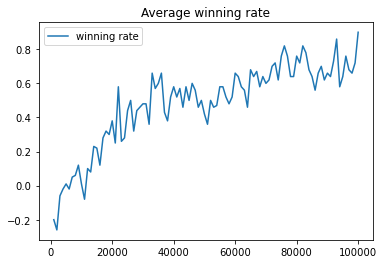

In [14]:
plt.plot(eval_t, avg_winning_rate, label='winning rate')
plt.legend()
plt.title('Average winning rate')
plt.show()

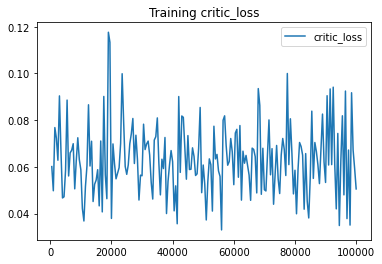

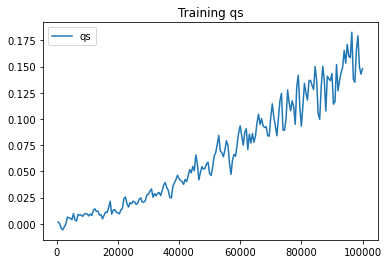

In [15]:
for k, v in training_stat.items():
    plt.plot(training_t, v, label=k)
    plt.legend()
    plt.title(f'Training {k}')
    plt.show()

Notice that the training process is far from convergence (the performance is still increasing, the q-values is not stable). Here I use a small `max_steps` for tutorial demonstration, leading to a training with less than 2 minutes. It requires much more training steps (> 10 million) to converge.

A longer training process  (approximately 1 hr on a single 4090 GPU) is saved here in the tensorboard for references (trained using [main.py](main.py) script):

``
%load_ext tensorboard
``
``
%tensorboard --logdir "results/tensorboard/dqn/20240319-183202"
``

![](tb_demo.png)